# Definición de modelo GAN para generación de imágenes
La siguiente celda de código define una red GAN, que tiene dos subredes, una para generar imágenes y otra para discriminar (identificar) si las imágenes generadas son distintas a las reales. Ambas redes se entrenan al mismo tiempo, de forma tal que a medida que la primera aprende a generar imágenes cada vez más reales, la segunda aprende a identificar si lo son realmente.


No es el objetivo entender todo el código, simplemente correr la celda para definir la red y luego entrenarla y usarla más abajo.

In [1]:


import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 2

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        print("Detalles del modelo generador:")
        model.summary()
        print("\n")

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        print("Detalles del modelo discriminador:")
        model.summary()
        print("\n")

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("Iteración %d → [Error D: %f, acc.: %.2f%%] [Error G: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                print("Ejemplo de imágenes generadas:")
                self.sample_images(epoch)
                


    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

# fijar la semilla
# no es necesario en la práctica, 
# lo hacemos para poder replicar los experimentos
tf.random.set_seed(0)
np.random.seed(0)
# definir la red
gan = GAN()

    

Detalles del modelo discriminador:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505

# Entrenamiento

El modelo se entrena con el conjunto de datos MNIST para aprender a generar imágenes de dígitos manuscritos. A medida que avanza el proceso las imágenes suelen ir mejorando. 

Probá modificar la cantidad de épocas o entrenarlo varias veces (equivalente) para ver como cambian.

11501568/11490434 [==============================] - 1s 0us/step
Iteración 0 → [Error D: 0.560069, acc.: 64.06%] [Error G: 0.812040]
Ejemplo de imágenes generadas:


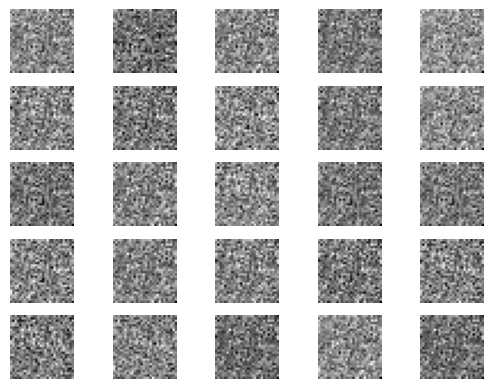

Iteración 500 → [Error D: 0.576899, acc.: 75.00%] [Error G: 1.194504]
Ejemplo de imágenes generadas:


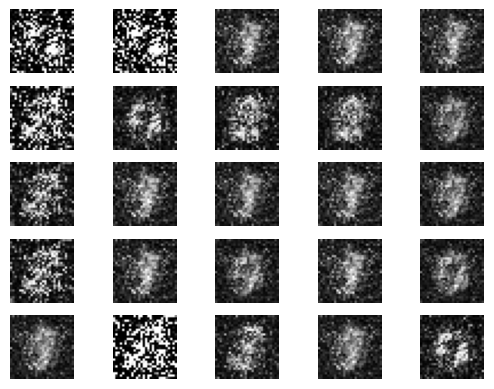

Iteración 1000 → [Error D: 0.632076, acc.: 64.06%] [Error G: 0.840318]
Ejemplo de imágenes generadas:


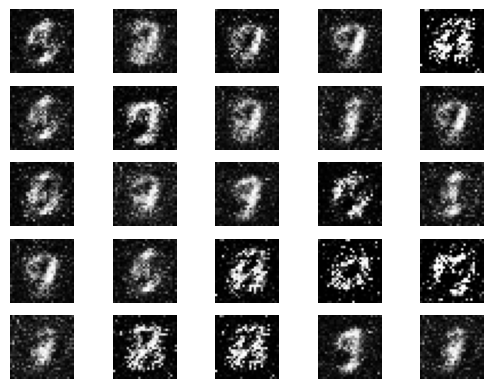

Iteración 1500 → [Error D: 0.646737, acc.: 62.50%] [Error G: 0.874289]
Ejemplo de imágenes generadas:


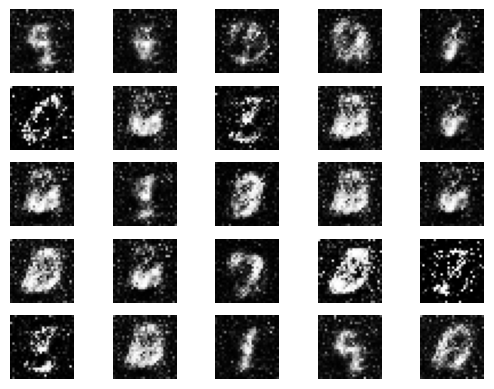

In [2]:
# Entrenar la red (tarda aprox. 10-15 minutos)
gan.train(epochs=2000, batch_size=32, sample_interval=500)

# Generación de imágenes con el modelo entrenado
En base a los valores de entrada num1 y num2, se genera la imagen. Probá modificarlos y ver si podés encontrar ciertos rangos de valores que generan cada dígito.

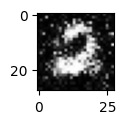

In [14]:
# Elegir dos números al azar, entre -1 y 1 preferentemente
num1=0.5
num2=0.1
# Generar un vector latente que codifica la imagen a generar con solo estos dos números
entrada = np.array([[num1,num2]])
# Generar la imagen
imagen_generada = gan.generator.predict(entrada)
# mostrarla
plt.figure(figsize = (1,1))
plt.imshow(imagen_generada[0,:,:,0],cmap="gray",)
# Ejecuta varias veces esta celda para ver como cambia la imagen generada
plt.show()